In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import src.plot_deep as plt_d
import src.models as md
import src.utils_deep as ud
import src.utils_preprocessing as up
import src.import_data as id
import pandas as pd

import torch
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda
Using device: cuda


c:\Users\grani\anaconda3\envs\torch_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_merged = id.import_data_merged(file_name="../data/merge/data_merged.csv")
embedding = np.load("../data/embeddings/embeddings_combined.npy")
vars_expl = id.vars_expl
vars_cibles = id.vars_cibles

emb_avec, emb_sans, X_avec, X_sans, y_avec, y_sans = id.sep_extr_X_y(
    df_merged, embedding, vars_expl= vars_expl, vars_cibles=vars_cibles
      )

train_loader_emb, val_loader_emb, test_loader_emb, scaler_X_emb, scaler_y_emb = up.split_2_DataLoader(emb_sans, emb_sans, val_size=0.8)
print("Taille Dataset Train :", len(train_loader_emb.dataset))
print("Taille Dataset Val :", len(val_loader_emb.dataset))
print("Taille Dataset Test :", len(test_loader_emb.dataset))

✓ Data loaded
  - df_merged shape: (6574, 28)
✓ Data séparée sur : Blé tendre
  - df_sans shape: (6473, 28)
  - df_avec shape: (101, 28)
Vérification - Avec : (101, 768) - Sans : (6473, 768)
Transformation faites - X_vars : (101, 10) - y : (101, 11)
Transformation faites - X_vars : (6473, 10) - y : (6473, 11)
Taille Dataset Train : 3883
Taille Dataset Val : 2072
Taille Dataset Test : 518


In [5]:
model_auto_encoder = md.MirrorAutoEncoder().to(device)
model_auto_encoder = ud.load_weights("../models/model_auto_Ba.pth", model_auto_encoder, device)

frozen_encoder = md.FrozenEncoder(model_auto_encoder.encoder).to(device)

In [6]:
# Transformation en tensor

X_emb_sans = torch.FloatTensor(emb_sans).to(device)
X_emb_avec = torch.FloatTensor(emb_avec).to(device)

# Inférence et réduction de dimensions

X_red_sans = frozen_encoder(X_emb_sans)
X_red_avec = frozen_encoder(X_emb_avec)

# Concaténation

X_combined_red_sans = np.hstack([X_red_sans.to("cpu"), X_sans])
X_combined_red_avec = np.hstack([X_red_avec.to("cpu"), X_avec])

In [7]:
train_loader_MLP, val_loader_MLP, test_loader_MLP, scaler_X_MLP, scaler_y_MLP = up.split_2_DataLoader(
    X_combined_red_sans, y_sans, train_size=0.7, val_size=0.8
    )

print("Taille Dataset Train :", len(train_loader_emb.dataset))
print("Taille Dataset Val :", len(val_loader_emb.dataset))
print("Taille Dataset Test :", len(test_loader_emb.dataset))

X_avec_scaled = scaler_X_MLP.transform(X_combined_red_avec)
y_avec_scaled = scaler_y_MLP.transform(y_avec)

avec_dataloader = up.tensor_2_DataLoader(X_avec_scaled, y_avec_scaled, shuffle_value=False)

Taille Dataset Train : 3883
Taille Dataset Val : 2072
Taille Dataset Test : 518


In [8]:
model_MLP = md.MLPRegressor(input_size=26, hidden_sizes=[128, 256, 64], output_size=11, dropout_rate=0.2).to(device)
model_MLP = ud.load_weights("../models/model_MLP_Ba.pth",model_MLP, device)

In [9]:
results_MLP = ud.Calcul_evaluation(
    model_MLP, train_loader_MLP, val_loader_MLP, avec_dataloader, scaler_y_MLP, device, vars_cibles
    )


SCENARIO 2 Results:

Train Set:
  R²:   0.9868 (±0.0032)
  RMSE: 59.6832 (±50.6208)
  MAE:  34.0550 (±28.4256)

Validation Set:
  R²:   0.9903 (±0.0018)
  RMSE: 43.7809 (±35.6403)
  MAE:  31.8521 (±26.4384)

Test Set (OOD - Feedtables):
  R²:   0.2804 (±0.6761)
  RMSE: 21.4114 (±18.8974)
  MAE:  17.1409 (±15.1557)


In [10]:
ud.print_regression_results(results_MLP, "MLP")


MLP - Performance per target variable:
Target                              R² (test)       RMSE            MAE            
--------------------------------------------------------------------------------
EB (kcal) kcal/kg brut               0.401             42.50            38.99
ED porc croissance (kcal) kcal/kg    0.712             32.28            25.13
EM porc croissance (kcal) kcal/kg    0.688             31.54            24.20
EN porc croissance (kcal) kcal/kg    0.683             21.18            16.48
EMAn coq (kcal) kcal/kg brut         0.233             47.04            37.26
EMAn poulet (kcal) kcal/kg brut      0.129             49.10            36.34
UFL 2018 par kg brut                 0.765              0.01             0.01
UFV 2018 par kg brut                 0.752              0.01             0.01
PDIA 2018 g/kg brut                  0.223              1.87             1.59
PDI 2018 g/kg brut                  -1.722              3.95             3.37
BalProRu 2018 g

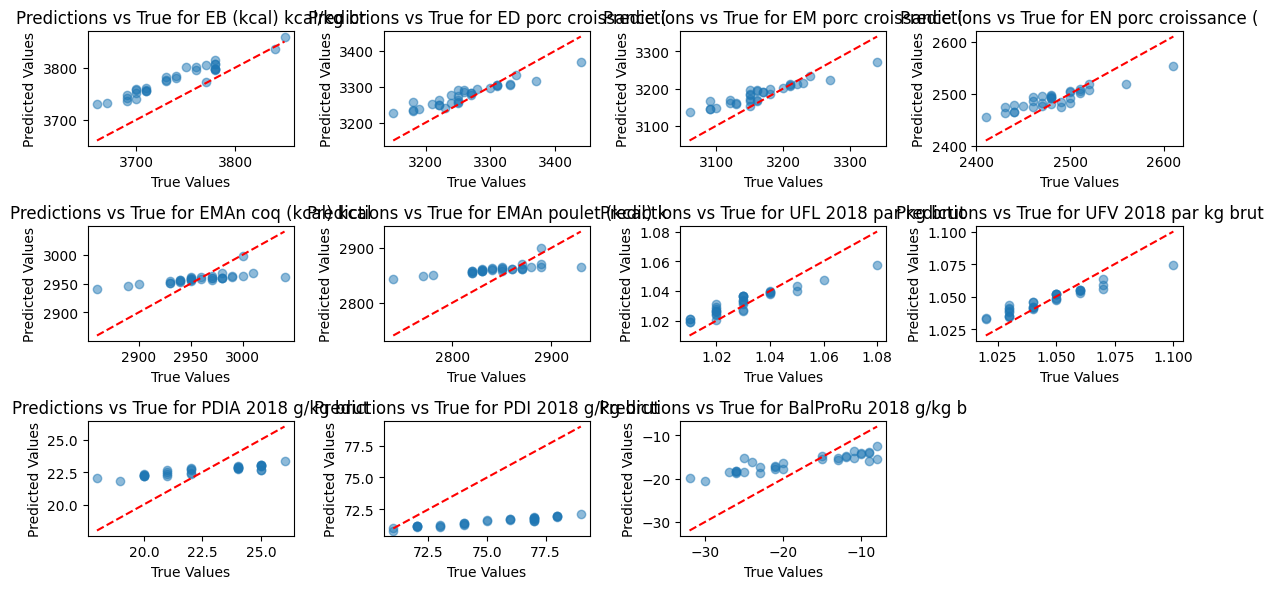

,type,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,true,3740.000000,3270.000000,3180.000000,2500.000000,2960.000000,2850.000000,1.030000,1.050000,20.999998,74.000000,-22.999998
1,pred,3779.204346,3276.331055,3185.118408,2492.068604,2960.910645,2863.243164,1.032682,1.047569,22.499472,71.434448,-17.327978
2,true,3700.000000,3180.000000,3090.000000,2430.000000,2890.000000,2770.000000,1.010000,1.030000,20.000002,72.000000,-26.999998
3,pred,3740.407959,3233.841797,3144.339355,2462.574707,2946.401855,2849.259766,1.020851,1.034842,22.261671,71.157295,-18.468000
4,true,3760.000000,3310.000000,3210.000000,2510.000000,2990.000000,2880.000000,1.040000,1.060000,24.000002,77.000000,-11.999998
5,pred,3800.426758,3301.673096,3208.080078,2504.909668,2962.476807,2864.850586,1.038581,1.053967,22.920343,71.846786,-14.753065
6,true,3840.000000,3340.000000,3240.000000,2520.000000,3010.000000,2890.000000,1.060000,1.070000,25.999998,79.000000,-7.999998
7,pred,3836.096436,3331.378906,3235.025391,2518.738037,2968.014893,2870.165771,1.047685,1.063737,23.311544,72.167465,-12.430510
8,true,3690.000000,3190.000000,3100.000000,2440.000000,2900.000000,2780.000000,1.010000,1.030000,20.000002,72.000000,-25.999998
9,pred,3741.324463,3236.622803,3147.085938,2465.130127,2948.359375,2851.371826,1.021312,1.035349,22.266470,71.171188,-18.353170


In [11]:
X_batch, y_batch_scaled = next(iter(avec_dataloader))
X_batch = X_batch.to(device)

model_MLP.eval()
with torch.no_grad():
    y_pred_scaled = model_MLP(X_batch).cpu().numpy()

y_true_scaled = y_batch_scaled.numpy()

# revenir à l’échelle originale
y_true = scaler_y_MLP.inverse_transform(y_true_scaled)
y_pred = scaler_y_MLP.inverse_transform(y_pred_scaled)


n = 5  # nombre d'exemples à afficher

rows = []
for i in range(n):
    rows.append(["true", *y_true[i]])
    rows.append(["pred", *y_pred[i]])

df_debug = pd.DataFrame(rows, columns=["type"] + vars_cibles)

plt_d.plot_real_vs_pred(y_true, y_pred, vars_cibles)
df_debug.head(10)

In [12]:
model_trans = md.NutritionTransformer().to(device)
model_trans = ud.load_weights("../models/model_trans_Ba.pth",model_trans, device)

c:\Users\grani\anaconda3\envs\torch_cuda\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [13]:
results_trans = ud.Calcul_evaluation(
    model_trans, train_loader_MLP, val_loader_MLP, avec_dataloader, scaler_y_MLP, device, vars_cibles, is_transformer = True
    )


SCENARIO 2 Results:

Train Set:
  R²:   0.9927 (±0.0020)
  RMSE: 44.8397 (±38.6022)
  MAE:  22.7606 (±20.5647)

Validation Set:
  R²:   0.9956 (±0.0012)
  RMSE: 29.4796 (±25.1959)
  MAE:  21.4202 (±19.3972)

Test Set (OOD - Feedtables):
  R²:   0.5106 (±0.3450)
  RMSE: 17.3806 (±18.0401)
  MAE:  15.5911 (±15.6651)


In [14]:
ud.print_regression_results(results_trans, "trans")


trans - Performance per target variable:
Target                              R² (test)       RMSE            MAE            
--------------------------------------------------------------------------------
EB (kcal) kcal/kg brut               0.891             18.11            17.14
ED porc croissance (kcal) kcal/kg    0.757             29.69            28.01
EM porc croissance (kcal) kcal/kg    0.826             23.55            22.08
EN porc croissance (kcal) kcal/kg    0.851             14.53            13.64
EMAn coq (kcal) kcal/kg brut        -0.063             55.38            47.59
EMAn poulet (kcal) kcal/kg brut      0.335             42.93            36.63
UFL 2018 par kg brut                 0.512              0.01             0.01
UFV 2018 par kg brut                 0.206              0.02             0.02
PDIA 2018 g/kg brut                  0.594              1.35             1.15
PDI 2018 g/kg brut                  -0.081              2.49             2.28
BalProRu 2018

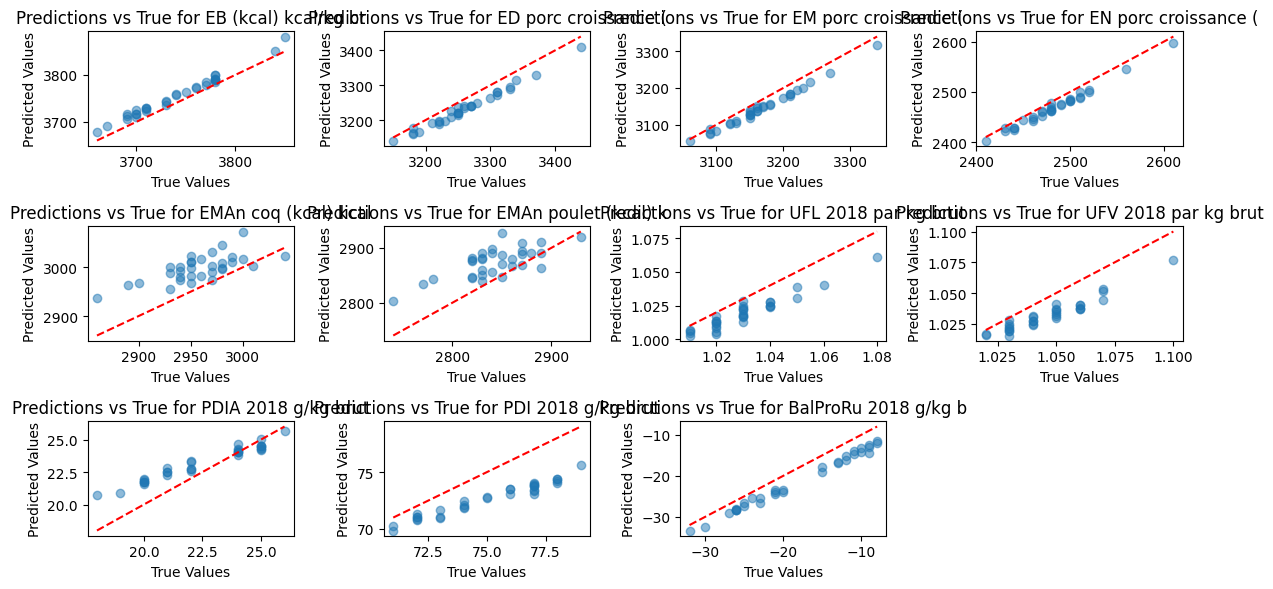

,type,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,true,3740.000000,3270.000000,3180.000000,2500.000000,2960.000000,2850.000000,1.030000,1.050000,20.999998,74.000000,-22.999998
1,pred,3759.956787,3239.699219,3152.669189,2481.182861,3016.358398,2888.011963,1.023318,1.036957,22.533121,72.078522,-25.476332
2,true,3700.000000,3180.000000,3090.000000,2430.000000,2890.000000,2770.000000,1.010000,1.030000,20.000002,72.000000,-26.999998
3,pred,3716.528320,3159.270508,3075.866699,2423.040039,2962.901123,2834.703857,1.006517,1.019039,21.601366,70.803764,-28.989477
4,true,3760.000000,3310.000000,3210.000000,2510.000000,2990.000000,2880.000000,1.040000,1.060000,24.000002,77.000000,-11.999998


In [15]:
X_batch, y_batch_scaled = next(iter(avec_dataloader))
X_batch = X_batch.to(device)

model_trans.eval()
with torch.no_grad():
    y_pred_scaled_trans = model_trans(X_batch).cpu().numpy()

y_true_scaled_trans = y_batch_scaled.numpy()

# revenir à l’échelle originale
y_true_trans = scaler_y_MLP.inverse_transform(y_true_scaled_trans)
y_pred_trans = scaler_y_MLP.inverse_transform(y_pred_scaled_trans)


n = 5  # nombre d'exemples à afficher

rows_trans = []
for i in range(n):
    rows_trans.append(["true", *y_true_trans[i]])
    rows_trans.append(["pred", *y_pred_trans[i]])

df_debug_trans = pd.DataFrame(rows_trans, columns=["type"] + vars_cibles)

plt_d.plot_real_vs_pred(y_true_trans, y_pred_trans, vars_cibles)

df_debug_trans.head()